In [1]:
import scipy.io

In [2]:
acmat = scipy.io.loadmat('AC.mat')

In [3]:
import numpy as np
import matplotlib as mpl
#mpl.use('pgf')

def figsize(scale, nplots = 1):
    fig_width_pt = 390.0                          # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = nplots*fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 10,               # LaTeX default is 10pt font.
    "font.size": 10,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "figure.figsize": figsize(1.0),     # default fig size of 0.9 textwidth
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }
mpl.rcParams.update(pgf_with_latex)

import matplotlib.pyplot as plt

# I make my own newfig and savefig functions
def newfig(width, nplots = 1):
    fig = plt.figure(figsize=figsize(width, nplots))
    ax = fig.add_subplot(111)
    return fig, ax

def savefig(filename, crop = True):
    if crop == True:
#        plt.savefig('{}.pgf'.format(filename), bbox_inches='tight', pad_inches=0)
        plt.savefig('{}.pdf'.format(filename), bbox_inches='tight', pad_inches=0)
        plt.savefig('{}.eps'.format(filename), bbox_inches='tight', pad_inches=0)
    else:
#        plt.savefig('{}.pgf'.format(filename))
        plt.savefig('{}.pdf'.format(filename))
        plt.savefig('{}.eps'.format(filename))

In [4]:
import sys
# sys.path.insert(0, '../../Utilities/')

import tensorflow as tf
import numpy as np
import jax
import matplotlib.pyplot as plt
import time
import scipy.io
# from plotting import newfig, savefig
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from jax import numpy as jnp
from jax import random as jran

/Users/shentingwei/opt/anaconda3/envs/pinnenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/shentingwei/opt/anaconda3/envs/pinnenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/shentingwei/opt/anaconda3/envs/pinnenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/shenti

In [54]:
seed = jran.PRNGKey(12)

In [57]:
def xavier_init(size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return xavier_stddev * jran.truncated_normal(seed, shape=[in_dim, out_dim], lower=-2*xavier_stddev, upper=2*xavier_stddev, dtype=jnp.float32)

In [58]:
xavier_init([1,2])

DeviceArray([[ 0.27016184, -0.66611934]], dtype=float32)

In [7]:
np.random.seed(1234)
tf.set_random_seed(1234)


class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x0, u0, x1, layers, dt, lb, ub, q):
        
        self.lb = lb
        self.ub = ub
        
        self.x0 = x0
        self.x1 = x1
        
        self.u0 = u0
        
        self.layers = layers
        self.dt = dt
        self.q = max(q,1)
    
        # Initialize NN
        self.weights, self.biases = self.initialize_NN(layers)
        
        # Load IRK weights
        tmp = np.float32(np.loadtxt('IRK_weights/Butcher_IRK%d.txt' % (q), ndmin = 2))
        self.IRK_weights = np.reshape(tmp[0:q**2+q], (q+1,q))
        self.IRK_times = tmp[q**2+q:]
        
        # tf placeholders and graph: replaced to JNP
#         self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
#                                                      log_device_placement=True))
        
#         self.x0_tf = tf.placeholder(tf.float32, shape=(None, self.x0.shape[1]))
#         self.x1_tf = tf.placeholder(tf.float32, shape=(None, self.x1.shape[1]))
#         self.u0_tf = tf.placeholder(tf.float32, shape=(None, self.u0.shape[1]))
#         self.dummy_x0_tf = tf.placeholder(tf.float32, shape=(None, self.q)) # dummy variable for fwd_gradients
#         self.dummy_x1_tf = tf.placeholder(tf.float32, shape=(None, self.q+1)) # dummy variable for fwd_gradients


        self.x0_jnp = jnp.zeros(shape=self.x0.shape, dtype=jnp.float32)
        self.x1_jnp = jnp.zeros(shape=self.x1.shape, dtype=jnp.float32)
        self.u0_jnp = jnp.zeros(shape=self.u0.shape, dtype=jnp.float32)
        self.dummy_x0_jnp = jnp.zeros(shape=(self.x0.shape[0], self.q), dtype=jnp.float32)
        self.dummy_x1_jnp = jnp.zeros(shape=(self.x1.shape[0], self.q+1), dtype=jnp.float32)
        
#         self.U0_pred = self.net_U0(self.x0_tf) # N x (q+1)
#         self.U1_pred, self.U1_x_pred= self.net_U1(self.x1_tf) # N1 x (q+1)
        self.U0_pred = self.net_U0(self.x0_jnp)
        self.U1_pred, self.U1_x_pred= self.net_U1(self.x1_jnp)
        
#         self.loss = tf.reduce_sum(tf.square(self.u0_tf - self.U0_pred)) + \
#                     tf.reduce_sum(tf.square(self.U1_pred[0,:] - self.U1_pred[1,:])) + \
#                     tf.reduce_sum(tf.square(self.U1_x_pred[0,:] - self.U1_x_pred[1,:]))   
        self.loss = jnp.sum(jnp.square(self.u0_jnp - self.U0_pred)) + \
                    jnp.sum(jnp.square(self.U1_pred[0,:] - self.U1_pred[1,:])) + \
                    jnp.sum(jnp.square(self.U1_x_pred[0,:] - self.U1_x_pred[1,:]))
    
        def loss_fn(u0, U0_pred, U1_pred, U1_x_pred):
            loss = jnp.sum(jnp.square(self.u0_jnp - self.U0_pred)) + \
                   np.sum(jnp.square(self.U1_pred[0,:] - self.U1_pred[1,:])) + \
                   jnp.sum(jnp.square(self.U1_x_pred[0,:] - self.U1_x_pred[1,:]))
            return loss
        self.loss_fn = loss_fn
        
#         self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
#                                                                 method = 'L-BFGS-B', 
#                                                                 options = {'maxiter': 50000,
#                                                                            'maxfun': 50000,
#                                                                            'maxcor': 50,
#                                                                            'maxls': 50,
#                                                                            'ftol' : 1.0 * np.finfo(float).eps})
# Just use jax.scipy.optimize.minimize later
        
#         self.optimizer_Adam = tf.train.AdamOptimizer()
#         self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        
        
#         init = tf.global_variables_initializer()
#         self.sess.run(init)
# Do not need this in JAX??
        
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = jnp.zeros(shape=[1,layers[l+1]], dtype=jnp.float32)
#             b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return xavier_stddev * jran.truncated_normal(seed, shape=[in_dim, out_dim], lower=-2*xavier_stddev, upper=2*xavier_stddev, dtype=jnp.float32)
#         return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
# Student Question
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = jnp.tanh(jnp.add(jnp.matmul(H, W), b))
#             H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = jnp.add(jnp.matmul(H, W), b)
        return Y
    
    def fwd_gradients_0(self, U, x):        
        g = tf.gradients(U, x, grad_ys=self.dummy_x0_tf)[0]
        return tf.gradients(g, self.dummy_x0_tf)[0]
    
    def fwd_gradients_1(self, U, x):        
        g = tf.gradients(U, x, grad_ys=self.dummy_x1_tf)[0]
        return tf.gradients(g, self.dummy_x1_tf)[0]
    
    def net_U0(self, x):
        U1 = self.neural_net(x, self.weights, self.biases)
        U = U1[:,:-1]
        U_x = self.fwd_gradients_0(U, x)
        U_xx = self.fwd_gradients_0(U_x, x)
        F = 5.0*U - 5.0*U**3 + 0.0001*U_xx
        U0 = U1 - self.dt*tf.matmul(F, self.IRK_weights.T)
        return U0

    def net_U1(self, x):
        U1 = self.neural_net(x, self.weights, self.biases)
        U1_x = self.fwd_gradients_1(U1, x)
        return U1, U1_x # N x (q+1)
    
    def callback(self, loss):
        print('Loss:', loss)
    
    def train(self, nIter):
        tf_dict = {self.x0_tf: self.x0, self.u0_tf: self.u0, self.x1_tf: self.x1,
                   self.dummy_x0_tf: np.ones((self.x0.shape[0], self.q)),
                   self.dummy_x1_tf: np.ones((self.x1.shape[0], self.q+1))}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value, elapsed))
                start_time = time.time()
    
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss],
                                loss_callback = self.callback)
    
    def predict(self, x_star):
        
        U1_star = self.sess.run(self.U1_pred, {self.x1_tf: x_star})
                    
        return U1_star

In [8]:
q = 100
layers = [1, 200, 200, 200, 200, q+1]
lb = np.array([-1.0])
ub = np.array([1.0])

N = 200

data = acmat

t = data['tt'].flatten()[:,None] # T x 1
x = data['x'].flatten()[:,None] # N x 1
Exact = np.real(data['uu']).T # T x N

idx_t0 = 20
idx_t1 = 180
dt = t[idx_t1] - t[idx_t0]

# Initial data
noise_u0 = 0.0
idx_x = np.random.choice(Exact.shape[1], N, replace=False) 
x0 = x[idx_x,:]
u0 = Exact[idx_t0:idx_t0+1,idx_x].T
u0 = u0 + noise_u0*np.std(u0)*np.random.randn(u0.shape[0], u0.shape[1])


# Boudanry data
x1 = np.vstack((lb,ub))

# Test data
x_star = x

model = PhysicsInformedNN(x0, u0, x1, layers, dt, lb, ub, q)
model.train(100)

U1_pred = model.predict(x_star)

error = np.linalg.norm(U1_pred[:,-1] - Exact[idx_t1,:], 2)/np.linalg.norm(Exact[idx_t1,:], 2)
print('Error: %e' % (error))


2022-12-01 17:43:45.621476: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-12-01 17:43:45.624771: I tensorflow/core/common_runtime/direct_session.cc:296] Device mapping:



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



2022-12-01 17:43:51.219287: I tensorflow/core/common_runtime/placer.cc:54] truncated_normal/TruncatedNormal: (TruncatedNormal)/job:localhost/replica:0/task:0/device:CPU:0
2022-12-01 17:43:51.219306: I tensorflow/core/common_runtime/placer.cc:54] truncated_normal/mul: (Mul)/job:localhost/replica:0/task:0/device:CPU:0
2022-12-01 17:43:51.219311: I tensorflow/core/common_runtime/placer.cc:54] truncated_normal: (Add)/job:localhost/replica:0/task:0/device:CPU:0
2022-12-01 17:43:51.219314: I tensorflow/core/common_runtime/placer.cc:54] Variable: (VariableV2)/job:localhost/replica:0/task:0/device:CPU:0
2022-12-01 17:43:51.219320: I tensorflow/core/common_runtime/placer.cc:54] Variable/Assign: (Assign)/job:localhost/replica:0/task:0/device:CPU:0
2022-12-01 17:43:51.219323: I tensorflow/core/common_runtime/placer.cc:54] Variable/read: (Identity)/job:localhost/replica:0/task:0/device:CPU:0
2022-12-01 17:43:51.219327: I tensorflow/core/common_runtime/placer.cc:54] Variable_1: (VariableV2)/job:loc

Device mapping: no known devices.
truncated_normal/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal: (Add): /job:localhost/replica:0/task:0/device:CPU:0
Variable: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable/Assign: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Variable/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1/Assign: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal_1/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal_1/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal_1: (Add): /job:localhost/replica:0/task:0/device:CPU:0
Variable_2: (VariableV2): /job:localhost/rep

gradients_7/gradients_3/gradients_2/It: 0, Loss: 4.055e+03, Time: 0.85
It: 10, Loss: 3.588e+03, Time: 0.11
It: 20, Loss: 3.571e+03, Time: 0.10
It: 30, Loss: 3.553e+03, Time: 0.12
It: 40, Loss: 3.545e+03, Time: 0.11
It: 50, Loss: 3.539e+03, Time: 0.11
It: 60, Loss: 3.528e+03, Time: 0.11
It: 70, Loss: 3.333e+03, Time: 0.11
It: 80, Loss: 2.919e+03, Time: 0.12
It: 90, Loss: 2.421e+03, Time: 0.11
Loss: 1941.458
Loss: 4449903.5
Loss: 1873.4291
Loss: 1829.9862
Loss: 1827.4297
Loss: 1823.8948
Loss: 1813.6202
Loss: 1800.6869
Loss: 1771.3937
Loss: 1746.1124
Loss: 1723.5938
Loss: 1715.8492
Loss: 1710.3043
Loss: 1708.0629
Loss: 1699.419
Loss: 1693.3634
Loss: 1681.7905
Loss: 1672.5264
Loss: 1667.5663
Loss: 1659.1147
Loss: 1652.678
Loss: 1650.2107
Loss: 1646.1075
Loss: 1643.8302
Loss: 1643.0059
Loss: 1641.7523
Loss: 1638.9019
Loss: 1637.1641
Loss: 1633.9581
Loss: 1633.0933
Loss: 1632.2823
Loss: 1630.0605
Loss: 1628.1083
Loss: 1627.3788
Loss: 1626.3165
Loss: 1624.1544
Loss: 1621.8761
Loss: 1620.9178


Loss: 456.51273
Loss: 455.28116
Loss: 455.34952
Loss: 454.86337
Loss: 454.62912
Loss: 453.6605
Loss: 453.87747
Loss: 453.4491
Loss: 453.13522
Loss: 452.7088
Loss: 452.50046
Loss: 452.26974
Loss: 451.88156
Loss: 451.5719
Loss: 451.24716
Loss: 450.8268
Loss: 469.2547
Loss: 450.7936
Loss: 450.41162
Loss: 450.23447
Loss: 468.31793
Loss: 449.93387
Loss: 449.61017
Loss: 449.3183
Loss: 448.97592
Loss: 448.11673
Loss: 447.45682
Loss: 451.9381
Loss: 446.94666
Loss: 446.29062
Loss: 445.46567
Loss: 445.2809
Loss: 444.96664
Loss: 444.7544
Loss: 444.94513
Loss: 444.56256
Loss: 444.16238
Loss: 443.89325
Loss: 443.72797
Loss: 443.6416
Loss: 443.52625
Loss: 443.372
Loss: 443.22803
Loss: 445.06393
Loss: 443.17056
Loss: 443.0205
Loss: 442.8691
Loss: 442.70987
Loss: 442.28116
Loss: 441.95972
Loss: 441.4178
Loss: 440.88992
Loss: 440.4054
Loss: 439.68637
Loss: 439.06064
Loss: 438.47153
Loss: 438.02145
Loss: 437.59222
Loss: 454.35947
Loss: 437.3848
Loss: 436.64688
Loss: 435.80768
Loss: 434.9085
Loss: 434.44

Loss: 358.47736
Loss: 358.3439
Loss: 358.02243
Loss: 357.8007
Loss: 357.54962
Loss: 357.24762
Loss: 357.09402
Loss: 357.0016
Loss: 356.9323
Loss: 356.81876
Loss: 356.68784
Loss: 356.6504
Loss: 356.38644
Loss: 356.27075
Loss: 356.12357
Loss: 356.01688
Loss: 355.9189
Loss: 355.7482
Loss: 355.5299
Loss: 355.27856
Loss: 355.02017
Loss: 354.81647
Loss: 354.64584
Loss: 373.9693
Loss: 354.58362
Loss: 354.39737
Loss: 356.48837
Loss: 354.25055
Loss: 354.01312
Loss: 353.60168
Loss: 353.44785
Loss: 353.13104
Loss: 352.6395
Loss: 352.229
Loss: 351.81738
Loss: 351.59122
Loss: 351.45242
Loss: 351.3175
Loss: 351.19293
Loss: 350.99384
Loss: 350.81476
Loss: 350.61157
Loss: 350.34058
Loss: 350.20596
Loss: 350.07626
Loss: 349.99176
Loss: 349.88583
Loss: 349.75552
Loss: 349.67178
Loss: 349.59457
Loss: 349.51617
Loss: 349.41876
Loss: 349.31863
Loss: 366.23376
Loss: 349.28912
Loss: 349.83017
Loss: 349.26343
Loss: 349.14896
Loss: 349.07602
Loss: 349.01242
Loss: 348.9439
Loss: 348.8537
Loss: 348.7983
Loss: 34

Loss: 312.7052
Loss: 312.62006
Loss: 312.5758
Loss: 312.54553
Loss: 312.52142
Loss: 312.49246
Loss: 312.49078
Loss: 312.47717
Loss: 312.44727
Loss: 312.42343
Loss: 312.39178
Loss: 312.3774
Loss: 312.43243
Loss: 312.3677
Loss: 312.34344
Loss: 312.29605
Loss: 312.13895
Loss: 311.9427
Loss: 311.84064
Loss: 311.73892
Loss: 311.68823
Loss: 311.6398
Loss: 311.60168
Loss: 311.54205
Loss: 311.50665
Loss: 311.92935
Loss: 311.4967
Loss: 311.46643
Loss: 311.43167
Loss: 311.39
Loss: 311.3664
Loss: 311.3527
Loss: 311.34277
Loss: 311.3732
Loss: 311.33176
Loss: 311.30743
Loss: 311.2457
Loss: 311.22278
Loss: 311.17722
Loss: 311.1376
Loss: 311.10236
Loss: 311.02768
Loss: 310.9721
Loss: 310.90518
Loss: 310.82037
Loss: 310.7229
Loss: 310.6254
Loss: 310.53046
Loss: 310.40906
Loss: 310.33902
Loss: 310.29077
Loss: 310.24225
Loss: 310.20575
Loss: 310.1431
Loss: 310.56857
Loss: 310.1163
Loss: 310.0517
Loss: 309.97443
Loss: 309.94434
Loss: 363.137
Loss: 309.94055
Loss: 309.9096
Loss: 309.86618
Loss: 309.82184


Loss: 298.9487
Loss: 298.90683
Loss: 298.84512
Loss: 298.7681
Loss: 298.71436
Loss: 298.69897
Loss: 298.67523
Loss: 298.67456
Loss: 298.666
Loss: 298.6529
Loss: 298.64658
Loss: 298.6414
Loss: 298.63867
Loss: 298.62805
Loss: 298.60812
Loss: 452.71362
Loss: 298.60062
Loss: 298.58835
Loss: 298.5676
Loss: 298.55103
Loss: 298.5347
Loss: 298.52142
Loss: 298.50336
Loss: 298.46616
Loss: 298.43442
Loss: 298.46918
Loss: 298.42
Loss: 298.38904
Loss: 298.36902
Loss: 298.35602
Loss: 298.3503
Loss: 298.3423
Loss: 298.3358
Loss: 298.32584
Loss: 298.3153
Loss: 298.31003
Loss: 298.55347
Loss: 298.30524
Loss: 298.29565
Loss: 298.28696
Loss: 298.27847
Loss: 298.26334
Loss: 298.2407
Loss: 298.21472
Loss: 298.1924
Loss: 298.24854
Loss: 298.18307
Loss: 298.16513
Loss: 298.1518
Loss: 298.13098
Loss: 298.10196
Loss: 298.08377
Loss: 298.0649
Loss: 298.19656
Loss: 298.05838
Loss: 298.04828
Loss: 297.99863
Loss: 297.96753
Loss: 297.93762
Loss: 297.91837
Loss: 297.89554
Loss: 297.86914
Loss: 297.86014
Loss: 297.8

Loss: 292.34027
Loss: 292.343
Loss: 292.33887
Loss: 292.33582
Loss: 292.33362
Loss: 292.33075
Loss: 292.32733
Loss: 292.32346
Loss: 292.31958
Loss: 292.3921
Loss: 292.31845
Loss: 292.31516
Loss: 292.31165
Loss: 292.35165
Loss: 292.31036
Loss: 292.3069
Loss: 292.30322
Loss: 292.2992
Loss: 292.29987
Loss: 292.29773
Loss: 292.29507
Loss: 292.29266
Loss: 292.29077
Loss: 292.28723
Loss: 292.28494
Loss: 292.28174
Loss: 293.27933
Loss: 292.2809
Loss: 292.27502
Loss: 292.26834
Loss: 292.26456
Loss: 292.26187
Loss: 292.25815
Loss: 292.25537
Loss: 292.25287
Loss: 292.2486
Loss: 292.24313
Loss: 292.23505
Loss: 292.27304
Loss: 292.2328
Loss: 292.22247
Loss: 292.21677
Loss: 292.21024
Loss: 292.20697
Loss: 292.2029
Loss: 292.1982
Loss: 292.1943
Loss: 292.1904
Loss: 292.4282
Loss: 292.18906
Loss: 292.1816
Loss: 292.17316
Loss: 292.1626
Loss: 292.14792
Loss: 292.22787
Loss: 292.1427
Loss: 292.13202
Loss: 292.11954
Loss: 292.11252
Loss: 292.10336
Loss: 292.08893
Loss: 292.10648
Loss: 292.086
Loss: 292.

Loss: 288.34976
Loss: 288.3119
Loss: 288.29413
Loss: 288.2705
Loss: 288.24454
Loss: 288.23608
Loss: 288.22906
Loss: 288.22345
Loss: 288.21896
Loss: 288.2142
Loss: 288.20694
Loss: 288.19315
Loss: 288.17484
Loss: 288.1612
Loss: 288.14975
Loss: 288.1383
Loss: 288.13098
Loss: 288.12436
Loss: 288.1114
Loss: 288.09885
Loss: 288.0968
Loss: 288.09
Loss: 288.07214
Loss: 288.05472
Loss: 288.04453
Loss: 288.03778
Loss: 288.0332
Loss: 288.02722
Loss: 288.01944
Loss: 288.01187
Loss: 288.0017
Loss: 288.01596
Loss: 287.9967
Loss: 288.30765
Loss: 287.99295
Loss: 289.00958
Loss: 287.98758
Loss: 287.97766
Loss: 287.94492
Loss: 287.9427
Loss: 287.9798
Loss: 287.92407
Loss: 287.91037
Loss: 287.887
Loss: 287.87216
Loss: 287.83597
Loss: 287.82858
Loss: 287.80914
Loss: 287.79776
Loss: 287.78748
Loss: 287.77496
Loss: 287.7634
Loss: 287.75732
Loss: 287.75204
Loss: 287.7451
Loss: 287.73477
Loss: 287.72516
Loss: 287.71616
Loss: 287.7076
Loss: 287.69797
Loss: 287.68817
Loss: 287.69354
Loss: 287.68372
Loss: 287.67

Loss: 248.39174
Loss: 248.1092
Loss: 247.83481
Loss: 247.69498
Loss: 247.5864
Loss: 247.51578
Loss: 247.34543
Loss: 247.08136
Loss: 246.67651
Loss: 246.37103
Loss: 245.94875
Loss: 245.53867
Loss: 245.24358
Loss: 244.75381
Loss: 244.35722
Loss: 243.7237
Loss: 243.14685
Loss: 242.40793
Loss: 243.2393
Loss: 242.23837
Loss: 241.60483
Loss: 248.66107
Loss: 241.4665
Loss: 241.08221
Loss: 240.6441
Loss: 240.42465
Loss: 240.20926
Loss: 240.01929
Loss: 239.84465
Loss: 239.24033
Loss: 264.54684
Loss: 238.64713
Loss: 237.52853
Loss: 236.63248
Loss: 236.33818
Loss: 235.93242
Loss: 235.73845
Loss: 235.50488
Loss: 235.28812
Loss: 235.06987
Loss: 234.87743
Loss: 261.55734
Loss: 234.68211
Loss: 234.49417
Loss: 234.18942
Loss: 234.02211
Loss: 233.70844
Loss: 232.77579
Loss: 239.94576
Loss: 232.59627
Loss: 232.20447
Loss: 231.6902
Loss: 231.32402
Loss: 230.96439
Loss: 230.63963
Loss: 230.17722
Loss: 229.68695
Loss: 230.99164
Loss: 229.45848
Loss: 229.12134
Loss: 229.54323
Loss: 228.8507
Loss: 228.55602


Loss: 75.09234
Loss: 74.973976
Loss: 74.93115
Loss: 74.804276
Loss: 74.76572
Loss: 74.71331
Loss: 74.67532
Loss: 74.63914
Loss: 74.61096
Loss: 74.58559
Loss: 74.573
Loss: 74.54985
Loss: 74.5017
Loss: 75.81873
Loss: 74.46019
Loss: 75.075554
Loss: 74.44086
Loss: 74.36961
Loss: 74.295
Loss: 74.24698
Loss: 74.16084
Loss: 74.10093
Loss: 74.02879
Loss: 73.94976
Loss: 74.40413
Loss: 73.91729
Loss: 74.3574
Loss: 73.81243
Loss: 73.708244
Loss: 73.48447
Loss: 73.25413
Loss: 73.059784
Loss: 72.93643
Loss: 72.8641
Loss: 72.77739
Loss: 72.733925
Loss: 72.67023
Loss: 72.56002
Loss: 72.388756
Loss: 72.256096
Loss: 72.12376
Loss: 71.936104
Loss: 71.774895
Loss: 71.676865
Loss: 71.56305
Loss: 71.42334
Loss: 71.24716
Loss: 71.1224
Loss: 71.77338
Loss: 71.073746
Loss: 70.96018
Loss: 71.20294
Loss: 70.8681
Loss: 70.77307
Loss: 70.64381
Loss: 70.4572
Loss: 70.310486
Loss: 70.21449
Loss: 70.15389
Loss: 70.11337
Loss: 70.076485
Loss: 70.0215
Loss: 69.97638
Loss: 70.159966
Loss: 69.95903
Loss: 70.08311
Loss: 

Loss: 43.56989
Loss: 43.53458
Loss: 43.51056
Loss: 43.46582
Loss: 43.41187
Loss: 43.38508
Loss: 43.31994
Loss: 43.295097
Loss: 43.273453
Loss: 43.25646
Loss: 43.236496
Loss: 43.19301
Loss: 45.016747
Loss: 43.15898
Loss: 43.095093
Loss: 43.035774
Loss: 43.01349
Loss: 42.990025
Loss: 42.9478
Loss: 42.911385
Loss: 42.88205
Loss: 42.84685
Loss: 42.826477
Loss: 42.80092
Loss: 42.77847
Loss: 42.762527
Loss: 42.748585
Loss: 42.738018
Loss: 42.718464
Loss: 42.69566
Loss: 42.67122
Loss: 42.65653
Loss: 42.627815
Loss: 42.604164
Loss: 42.57605
Loss: 42.5624
Loss: 42.510204
Loss: 42.4681
Loss: 42.44405
Loss: 42.42601
Loss: 42.412807
Loss: 42.37195
Loss: 42.301647
Loss: 42.247982
Loss: 42.224117
Loss: 42.20303
Loss: 42.18757
Loss: 42.169594
Loss: 42.098827
Loss: 42.10083
Loss: 42.03734
Loss: 42.02595
Loss: 41.960705
Loss: 41.94955
Loss: 41.940556
Loss: 41.924088
Loss: 41.898006
Loss: 41.875557
Loss: 41.818542
Loss: 42.10771
Loss: 41.7941
Loss: 41.757034
Loss: 41.729443
Loss: 41.69484
Loss: 41.67439

Loss: 28.04194
Loss: 28.014126
Loss: 27.995792
Loss: 27.970564
Loss: 27.955843
Loss: 27.929976
Loss: 27.911842
Loss: 27.883862
Loss: 27.871166
Loss: 27.821276
Loss: 27.80652
Loss: 27.787535
Loss: 27.771788
Loss: 27.756508
Loss: 27.739975
Loss: 27.70383
Loss: 27.655104
Loss: 27.606558
Loss: 27.567406
Loss: 27.549318
Loss: 27.5327
Loss: 27.503784
Loss: 27.47742
Loss: 27.496143
Loss: 27.44546
Loss: 27.378382
Loss: 27.30275
Loss: 27.274265
Loss: 27.254534
Loss: 27.241041
Loss: 27.233757
Loss: 27.207548
Loss: 27.178028
Loss: 27.143713
Loss: 27.090193
Loss: 27.027311
Loss: 26.980015
Loss: 26.912895
Loss: 26.944208
Loss: 26.884083
Loss: 26.844688
Loss: 26.817251
Loss: 26.80647
Loss: 26.796425
Loss: 26.764538
Loss: 26.762594
Loss: 26.73966
Loss: 26.704723
Loss: 26.686106
Loss: 26.65528
Loss: 26.633612
Loss: 26.613194
Loss: 26.597452
Loss: 26.582724
Loss: 26.56098
Loss: 26.517668
Loss: 26.472273
Loss: 26.43409
Loss: 26.7914
Loss: 26.40618
Loss: 26.348192
Loss: 26.311445
Loss: 26.284836
Loss: 26

Loss: 13.43919
Loss: 13.42038
Loss: 13.408392
Loss: 13.398742
Loss: 13.381311
Loss: 13.369687
Loss: 13.339277
Loss: 13.322271
Loss: 13.291526
Loss: 13.261787
Loss: 13.240464
Loss: 13.346764
Loss: 13.227813
Loss: 13.203141
Loss: 13.17342
Loss: 13.151963
Loss: 13.132842
Loss: 13.121863
Loss: 13.140907
Loss: 13.116629
Loss: 13.100656
Loss: 13.088019
Loss: 13.07197
Loss: 13.0622635
Loss: 13.045571
Loss: 13.024821
Loss: 12.995323
Loss: 12.963674
Loss: 13.04473
Loss: 12.946447
Loss: 12.928986
Loss: 12.905797
Loss: 12.864366
Loss: 12.849932
Loss: 12.843531
Loss: 12.835974
Loss: 12.826341
Loss: 12.816562
Loss: 12.798308
Loss: 12.776933
Loss: 12.75639
Loss: 12.745467
Loss: 12.737015
Loss: 12.722507
Loss: 14.126803
Loss: 12.717173
Loss: 12.698583
Loss: 12.680585
Loss: 12.667931
Loss: 12.659068
Loss: 12.653398
Loss: 12.642936
Loss: 12.616626
Loss: 12.618623
Loss: 12.6026745
Loss: 12.573025
Loss: 12.550178
Loss: 12.533696
Loss: 12.520945
Loss: 12.498386
Loss: 12.60155
Loss: 12.491475
Loss: 12.4688

Loss: 8.483109
Loss: 8.466074
Loss: 8.458211
Loss: 8.581601
Loss: 8.449419
Loss: 8.436338
Loss: 8.423659
Loss: 8.412621
Loss: 8.389462
Loss: 8.3538265
Loss: 8.335702
Loss: 8.32785
Loss: 8.322056
Loss: 8.318156
Loss: 8.315298
Loss: 8.310407
Loss: 8.306404
Loss: 8.294748
Loss: 8.402815
Loss: 8.283677
Loss: 8.26647
Loss: 8.259218
Loss: 8.254687
Loss: 8.241106
Loss: 8.233967
Loss: 8.217124
Loss: 8.196009
Loss: 8.181427
Loss: 8.1741295
Loss: 8.169231
Loss: 8.166942
Loss: 8.158886
Loss: 8.147105
Loss: 8.170716
Loss: 8.140612
Loss: 8.130055
Loss: 9.385066
Loss: 8.120014
Loss: 8.105121
Loss: 8.090965
Loss: 8.084076
Loss: 8.075034
Loss: 8.051671
Loss: 8.033375
Loss: 8.0140295
Loss: 8.005623
Loss: 7.997039
Loss: 7.9880643
Loss: 7.971182
Loss: 7.955129
Loss: 7.9218607
Loss: 7.876839
Loss: 7.847043
Loss: 7.82614
Loss: 7.8163614
Loss: 7.8092203
Loss: 7.8041353
Loss: 7.7973557
Loss: 7.7893972
Loss: 7.781594
Loss: 7.770286
Loss: 7.7623
Loss: 7.756069
Loss: 7.747304
Loss: 7.73359
Loss: 7.8046737
Loss:

Loss: 4.600071
Loss: 4.596113
Loss: 4.593823
Loss: 4.592191
Loss: 4.5885644
Loss: 4.5866065
Loss: 4.584555
Loss: 4.583187
Loss: 4.5825024
Loss: 4.579907
Loss: 4.582097
Loss: 4.578184
Loss: 4.5755835
Loss: 4.573806
Loss: 4.570326
Loss: 4.5673223
Loss: 4.5643983
Loss: 4.561735
Loss: 4.5604286
Loss: 4.5588565
Loss: 4.556017
Loss: 4.5514717
Loss: 4.547906
Loss: 4.551508
Loss: 4.545259
Loss: 4.542964
Loss: 4.5414343
Loss: 4.539002
Loss: 4.5296354
Loss: 4.5264316
Loss: 4.5232677
Loss: 4.521311
Loss: 4.519504
Loss: 4.515217
Loss: 4.5334477
Loss: 4.5135665
Loss: 4.5096545
Loss: 4.505463
Loss: 4.503145
Loss: 4.5011454
Loss: 4.498755
Loss: 4.493324
Loss: 4.5764976
Loss: 4.491503
Loss: 4.481709
Loss: 4.4776764
Loss: 4.4724913
Loss: 4.4691777
Loss: 4.4627366
Loss: 4.455321
Loss: 4.447895
Loss: 4.4430385
Loss: 4.439517
Loss: 4.4379964
Loss: 4.4321694
Loss: 4.4278517
Loss: 4.4253397
Loss: 4.43223
Loss: 4.422684
Loss: 4.4172072
Loss: 4.407788
Loss: 4.401492
Loss: 4.401295
Loss: 4.3992686
Loss: 4.3954

Loss: 2.2266104
Loss: 2.2205052
Loss: 2.2530913
Loss: 2.2183015
Loss: 2.213881
Loss: 2.2091556
Loss: 2.204847
Loss: 2.1995683
Loss: 2.1926336
Loss: 2.188988
Loss: 2.1854541
Loss: 2.1832364
Loss: 2.180611
Loss: 2.1776514
Loss: 2.1749408
Loss: 2.1728752
Loss: 2.1713479
Loss: 2.1697488
Loss: 2.1676497
Loss: 2.1663268
Loss: 2.1636617
Loss: 2.1592505
Loss: 2.1569626
Loss: 2.1534405
Loss: 2.1564379
Loss: 2.1508026
Loss: 2.1453211
Loss: 2.1421607
Loss: 2.1393263
Loss: 2.137057
Loss: 2.1340725
Loss: 2.1300712
Loss: 2.1284988
Loss: 2.121733
Loss: 2.1222317
Loss: 2.11904
Loss: 2.1160822
Loss: 2.1119
Loss: 2.1101289
Loss: 2.1069446
Loss: 2.1052659
Loss: 2.1006837
Loss: 2.0980217
Loss: 2.0964172
Loss: 2.112878
Loss: 2.0957088
Loss: 2.0949657
Loss: 2.0940692
Loss: 2.093328
Loss: 2.0916665
Loss: 2.089838
Loss: 2.1309395
Loss: 2.089309
Loss: 2.087302
Loss: 2.085152
Loss: 2.0828738
Loss: 2.0801373
Loss: 2.0775464
Loss: 2.0764039
Loss: 2.0748103
Loss: 2.0737705
Loss: 2.0730133
Loss: 2.0716846
Loss: 2.0

Loss: 1.4272733
Loss: 1.4264879
Loss: 1.4256974
Loss: 1.4248369
Loss: 1.4235168
Loss: 1.4220695
Loss: 1.4208018
Loss: 1.4198349
Loss: 1.418116
Loss: 1.4166163
Loss: 1.4147593
Loss: 1.413258
Loss: 1.4116235
Loss: 1.4103475
Loss: 1.409415
Loss: 1.4089335
Loss: 1.4086754
Loss: 1.408207
Loss: 1.4076387
Loss: 1.4067863
Loss: 1.4058678
Loss: 1.4052633
Loss: 1.404555
Loss: 1.4042044
Loss: 1.403215
Loss: 1.4025233
Loss: 1.401589
Loss: 1.4010156
Loss: 1.399997
Loss: 1.3989846
Loss: 1.3981797
Loss: 1.3974861
Loss: 1.3970721
Loss: 1.3960878
Loss: 1.3955957
Loss: 1.3951572
Loss: 1.3946548
Loss: 1.3939875
Loss: 1.3932273
Loss: 1.3924054
Loss: 1.391129
Loss: 1.3901035
Loss: 1.3886615
Loss: 1.3878461
Loss: 1.3857445
Loss: 1.384653
Loss: 1.3833078
Loss: 1.470216
Loss: 1.3830888
Loss: 1.3822367
Loss: 1.3812821
Loss: 1.3796614
Loss: 1.3876313
Loss: 1.3790473
Loss: 1.3784627
Loss: 1.3781252
Loss: 1.3778188
Loss: 1.376982
Loss: 1.376407
Loss: 1.3759122
Loss: 1.375581
Loss: 1.3751714
Loss: 1.3746394
Loss: 

Loss: 1.0646827
Loss: 1.0638872
Loss: 1.062842
Loss: 1.0621966
Loss: 1.061723
Loss: 1.0612161
Loss: 1.060546
Loss: 1.0672367
Loss: 1.0603857
Loss: 1.0597483
Loss: 1.0591736
Loss: 1.0584129
Loss: 1.0577416
Loss: 1.0564709
Loss: 1.0555189
Loss: 1.054747
Loss: 1.053999
Loss: 1.0532132
Loss: 1.0524888
Loss: 1.0517975
Loss: 1.0513977
Loss: 1.050993
Loss: 1.0507518
Loss: 1.0495449
Loss: 1.0489103
Loss: 1.0480108
Loss: 1.0467774
Loss: 1.0466973
Loss: 1.0461824
Loss: 1.0453981
Loss: 1.0450901
Loss: 1.0444691
Loss: 1.0440212
Loss: 1.0436015
Loss: 1.0429913
Loss: 1.0425143
Loss: 1.0420316
Loss: 1.0410361
Loss: 1.0405263
Loss: 1.0399957
Loss: 1.0394322
Loss: 1.0387914
Loss: 1.037533
Loss: 1.0368981
Loss: 1.0357535
Loss: 1.0348868
Loss: 1.0343622
Loss: 1.0338237
Loss: 1.0334278
Loss: 1.0331091
Loss: 1.0318147
Loss: 1.0329877
Loss: 1.0309958
Loss: 1.0300485
Loss: 1.0291501
Loss: 1.0284264
Loss: 1.0278119
Loss: 1.0274262
Loss: 1.0269872
Loss: 1.0260148
Loss: 1.025296
Loss: 1.02431
Loss: 1.0234007
Lo

Loss: 0.78652275
Loss: 0.7861438
Loss: 0.785737
Loss: 0.7848879
Loss: 0.7841068
Loss: 0.78356
Loss: 0.78329897
Loss: 0.783024
Loss: 0.7826303
Loss: 0.78209203
Loss: 0.78184295
Loss: 0.78169674
Loss: 0.7815617
Loss: 0.781471
Loss: 0.7811533
Loss: 0.7808033
Loss: 0.7801548
Loss: 0.7834025
Loss: 0.77990156
Loss: 0.7794682
Loss: 0.77901405
Loss: 0.77877015
Loss: 0.7783371
Loss: 0.77802366
Loss: 0.77770275
Loss: 0.77809197
Loss: 0.7776097
Loss: 0.7772541
Loss: 0.7769106
Loss: 0.77657074
Loss: 0.776127
Loss: 0.77539694
Loss: 0.7749537
Loss: 0.77465814
Loss: 0.77443886
Loss: 0.77414894
Loss: 0.77383196
Loss: 0.7735609
Loss: 0.7733988
Loss: 0.7733106
Loss: 0.77278584
Loss: 0.7724975
Loss: 0.7720209
Loss: 0.7717546
Loss: 0.7710583
Loss: 0.7706125
Loss: 0.7702383
Loss: 0.76993567
Loss: 0.7695588
Loss: 0.7691335
Loss: 0.7686853
Loss: 0.76833147
Loss: 0.7679886
Loss: 0.7676111
Loss: 0.767346
Loss: 0.76708513
Loss: 0.76681685
Loss: 0.766648
Loss: 0.76588583
Loss: 0.7706392
Loss: 0.7656344
Loss: 0.7

Loss: 0.617334
Loss: 0.6170512
Loss: 0.6166292
Loss: 0.61595285
Loss: 0.6153494
Loss: 0.6146877
Loss: 0.6373993
Loss: 0.61446756
Loss: 0.61396885
Loss: 0.6131541
Loss: 0.6129398
Loss: 0.61272097
Loss: 0.6123636
Loss: 0.61207944
Loss: 0.6119739
Loss: 0.6119416
Loss: 0.6118587
Loss: 0.61178714
Loss: 0.6116665
Loss: 0.61145157
Loss: 0.61118954
Loss: 0.6106584
Loss: 0.6103084
Loss: 0.6096448
Loss: 0.61005455
Loss: 0.60933876
Loss: 0.6089734
Loss: 0.6112618
Loss: 0.60879356
Loss: 0.6085665
Loss: 0.60833853
Loss: 0.60803944
Loss: 0.60774326
Loss: 0.6073175
Loss: 0.606977
Loss: 0.60668564
Loss: 0.60671777
Loss: 0.6065456
Loss: 0.60630345
Loss: 0.60607815
Loss: 0.60580385
Loss: 0.6055403
Loss: 0.60533106
Loss: 0.60513043
Loss: 0.60500425
Loss: 0.60491645
Loss: 0.60479176
Loss: 0.6046421
Loss: 0.6095221
Loss: 0.604598
Loss: 0.60449934
Loss: 0.6042448
Loss: 0.60417044
Loss: 0.60369307
Loss: 0.603552
Loss: 0.603278
Loss: 0.6029281
Loss: 0.603281
Loss: 0.602684
Loss: 0.6024276
Loss: 0.6022055
Loss

Loss: 0.49684212
Loss: 0.49704045
Loss: 0.49670878
Loss: 0.4963465
Loss: 0.49619025
Loss: 0.49567875
Loss: 0.51349133
Loss: 0.49541557
Loss: 0.49496114
Loss: 0.49468204
Loss: 0.49441844
Loss: 0.4940471
Loss: 0.49377912
Loss: 0.493548
Loss: 0.4934574
Loss: 0.49360257
Loss: 0.49340114
Loss: 0.49327022
Loss: 0.49304882
Loss: 0.49281418
Loss: 0.49261153
Loss: 0.4923754
Loss: 0.49210292
Loss: 0.4918093
Loss: 0.4949991
Loss: 0.49162638
Loss: 0.4912528
Loss: 0.49101692
Loss: 0.4906692
Loss: 0.490403
Loss: 0.49015406
Loss: 0.48974973
Loss: 0.4893813
Loss: 0.48945034
Loss: 0.48918316
Loss: 0.48896283
Loss: 0.4885835
Loss: 0.48843175
Loss: 0.48791188
Loss: 0.4875402
Loss: 0.48714975
Loss: 0.48684072
Loss: 0.48638177
Loss: 0.48562017
Loss: 0.48515403
Loss: 0.484793
Loss: 0.4845512
Loss: 0.48440146
Loss: 0.484194
Loss: 0.48396155
Loss: 0.484783
Loss: 0.48382786
Loss: 0.48360962
Loss: 0.48340684
Loss: 0.4832017
Loss: 0.48273447
Loss: 0.48211595
Loss: 0.48186806
Loss: 0.48160553
Loss: 0.48149097
Los

Loss: 0.40353778
Loss: 0.4034647
Loss: 0.40338796
Loss: 0.40320832
Loss: 0.40342563
Loss: 0.4031432
Loss: 0.40299183
Loss: 0.4027516
Loss: 0.40256467
Loss: 0.4023823
Loss: 0.4022149
Loss: 0.40214437
Loss: 0.4019104
Loss: 0.4017818
Loss: 0.4016671
Loss: 0.4015449
Loss: 0.401399
Loss: 0.40125746
Loss: 0.40108833
Loss: 0.40107632
Loss: 0.40089828
Loss: 0.40080947
Loss: 0.40067807
Loss: 0.40048367
Loss: 0.40020922
Loss: 0.40086612
Loss: 0.40011522
Loss: 0.39987007
Loss: 0.39965546
Loss: 0.3994323
Loss: 0.39920676
Loss: 0.39905062
Loss: 0.3989455
Loss: 0.3988568
Loss: 0.39875257
Loss: 0.39860064
Loss: 0.4030383
Loss: 0.39845893
Loss: 0.39831686
Loss: 0.39809114
Loss: 0.3979911
Loss: 0.39781952
Loss: 0.39775345
Loss: 0.39765903
Loss: 0.39758226
Loss: 0.3975163
Loss: 0.39736623
Loss: 0.39757013
Loss: 0.39727682
Loss: 0.3970449
Loss: 0.3969313
Loss: 0.39660412
Loss: 0.39635047
Loss: 0.3961628
Loss: 0.3959881
Loss: 0.39581248
Loss: 0.39563665
Loss: 0.3954023
Loss: 0.3980048
Loss: 0.39534706
Los

Loss: 0.3124338
Loss: 0.31228164
Loss: 0.31208685
Loss: 0.3119559
Loss: 0.31169245
Loss: 0.31158936
Loss: 0.31142434
Loss: 0.31119382
Loss: 0.31084147
Loss: 0.3113902
Loss: 0.31073776
Loss: 0.3105327
Loss: 0.3104409
Loss: 0.3102853
Loss: 0.31019416
Loss: 0.3100917
Loss: 0.3099698
Loss: 0.30987784
Loss: 0.3096734
Loss: 0.30956805
Loss: 0.30917627
Loss: 0.3090372
Loss: 0.308912
Loss: 0.3087867
Loss: 0.30882755
Loss: 0.3086691
Loss: 0.30848897
Loss: 0.30832437
Loss: 0.30817142
Loss: 0.3080179
Loss: 0.30870998
Loss: 0.30794507
Loss: 0.30784753
Loss: 0.30770233
Loss: 0.3075566
Loss: 0.30738723
Loss: 0.3070813
Loss: 0.307067
Loss: 0.30698022
Loss: 0.30684993
Loss: 0.30629638
Loss: 0.3060271
Loss: 0.30554017
Loss: 0.30924115
Loss: 0.30545607
Loss: 0.3051471
Loss: 0.30489752
Loss: 0.30478752
Loss: 0.30465588
Loss: 0.30434412
Loss: 0.3043322
Loss: 0.30422592
Loss: 0.30404717
Loss: 0.30397534
Loss: 0.30390686
Loss: 0.3038444
Loss: 0.30373326
Loss: 0.3035501
Loss: 0.30340913
Loss: 0.30326444
Loss

Loss: 0.23567763
Loss: 0.23633894
Loss: 0.2356157
Loss: 0.23544534
Loss: 0.23532416
Loss: 0.23522829
Loss: 0.2350497
Loss: 0.23495051
Loss: 0.23455308
Loss: 0.23430492
Loss: 0.2340723
Loss: 0.23386
Loss: 0.23393244
Loss: 0.23367642
Loss: 0.23354355
Loss: 0.23337236
Loss: 0.23325446
Loss: 0.23311582
Loss: 0.23323984
Loss: 0.23300767
Loss: 0.23280472
Loss: 0.2327268
Loss: 0.23250537
Loss: 0.23238912
Loss: 0.23231788
Loss: 0.23228839
Loss: 0.23217422
Loss: 0.23202136
Loss: 0.23246138
Loss: 0.23196505
Loss: 0.23179188
Loss: 0.23164348
Loss: 0.23146425
Loss: 0.23134851
Loss: 0.231253
Loss: 0.23115176
Loss: 0.23109429
Loss: 0.23106411
Loss: 0.23097491
Loss: 0.23081867
Loss: 0.2307505
Loss: 0.23054919
Loss: 0.23036149
Loss: 0.23018667
Loss: 0.23026018
Loss: 0.23005559
Loss: 0.229945
Loss: 0.2296412
Loss: 0.22946051
Loss: 0.22927243
Loss: 0.22892721
Loss: 0.22855762
Loss: 0.22854584
Loss: 0.22832295
Loss: 0.22807449
Loss: 0.22793917
Loss: 0.22772223
Loss: 0.22736113
Loss: 0.22762299
Loss: 0.22

Loss: 0.18125509
Loss: 0.18014254
Loss: 0.18009016
Loss: 0.18003672
Loss: 0.18001293
Loss: 0.17995644
Loss: 0.17987943
Loss: 0.17981343
Loss: 0.17970648
Loss: 0.18006746
Loss: 0.17967509
Loss: 0.1795481
Loss: 0.17945753
Loss: 0.1792822
Loss: 0.17915514
Loss: 0.17901509
Loss: 0.17877854
Loss: 0.17858392
Loss: 0.1783094
Loss: 0.17797242
Loss: 0.1793846
Loss: 0.17773536
Loss: 0.17746522
Loss: 0.17726734
Loss: 0.17691505
Loss: 0.17677353
Loss: 0.17670077
Loss: 0.17663631
Loss: 0.17654322
Loss: 0.17651908
Loss: 0.17629227
Loss: 0.17618634
Loss: 0.17605723
Loss: 0.17598125
Loss: 0.1759909
Loss: 0.17592548
Loss: 0.17581294
Loss: 0.17568748
Loss: 0.17557736
Loss: 0.17543492
Loss: 0.17529488
Loss: 0.17522286
Loss: 0.17512105
Loss: 0.17501363
Loss: 0.17576018
Loss: 0.17497368
Loss: 0.17482871
Loss: 0.17475872
Loss: 0.17464402
Loss: 0.1745051
Loss: 0.17434636
Loss: 0.17420882
Loss: 0.17407168
Loss: 0.17398673
Loss: 0.1739197
Loss: 0.17382638
Loss: 0.17370294
Loss: 0.17349261
Loss: 0.17354208
Loss

Loss: 0.13598195
Loss: 0.13589126
Loss: 0.13584799
Loss: 0.13576613
Loss: 0.13575236
Loss: 0.13562648
Loss: 0.13554017
Loss: 0.13541265
Loss: 0.13530776
Loss: 0.13521159
Loss: 0.13507712
Loss: 0.1349556
Loss: 0.13482542
Loss: 0.13469899
Loss: 0.1346537
Loss: 0.13456887
Loss: 0.13453875
Loss: 0.13450181
Loss: 0.1344355
Loss: 0.13432887
Loss: 0.13449569
Loss: 0.13427047
Loss: 0.13413191
Loss: 0.13405204
Loss: 0.13397926
Loss: 0.13388886
Loss: 0.1337733
Loss: 0.13360581
Loss: 0.13352303
Loss: 0.13342503
Loss: 0.1344116
Loss: 0.13340223
Loss: 0.13333611
Loss: 0.13319297
Loss: 0.13315031
Loss: 0.13308215
Loss: 0.13302985
Loss: 0.13297637
Loss: 0.13293867
Loss: 0.13289428
Loss: 0.13284515
Loss: 0.13275576
Loss: 0.13275325
Loss: 0.13270122
Loss: 0.13260618
Loss: 0.13253976
Loss: 0.13245465
Loss: 0.1322454
Loss: 0.13288291
Loss: 0.13218328
Loss: 0.13201872
Loss: 0.13190131
Loss: 0.13170277
Loss: 0.13152334
Loss: 0.13145882
Loss: 0.13133231
Loss: 0.13128765
Loss: 0.13123375
Loss: 0.13113353
Los

Loss: 0.110742964
Loss: 0.11072532
Loss: 0.11068687
Loss: 0.11066891
Loss: 0.11062753
Loss: 0.11060356
Loss: 0.110560745
Loss: 0.110564366
Loss: 0.11054834
Loss: 0.11052972
Loss: 0.11049272
Loss: 0.1104997
Loss: 0.11047289
Loss: 0.11045064
Loss: 0.11039132
Loss: 0.11035017
Loss: 0.11029591
Loss: 0.11024255
Loss: 0.11021194
Loss: 0.11017256
Loss: 0.11011249
Loss: 0.11008053
Loss: 0.1100169
Loss: 0.10992838
Loss: 0.111738876
Loss: 0.10990437
Loss: 0.109856226
Loss: 0.10978248
Loss: 0.109727755
Loss: 0.10964131
Loss: 0.10954339
Loss: 0.109507695
Loss: 0.1094914
Loss: 0.109469175
Loss: 0.109433435
Loss: 0.109355584
Loss: 0.10926089
Loss: 0.109390914
Loss: 0.10922531
Loss: 0.10913082
Loss: 0.1090754
Loss: 0.108980976
Loss: 0.10897006
Loss: 0.10890355
Loss: 0.10886366
Loss: 0.10884124
Loss: 0.10883923
Loss: 0.1088193
Loss: 0.1088109
Loss: 0.108782955
Loss: 0.10877039
Loss: 0.10874188
Loss: 0.10868817
Loss: 0.108603574
Loss: 0.10887076
Loss: 0.10857651
Loss: 0.10851587
Loss: 0.10846258
Loss: 

Loss: 0.09368146
Loss: 0.0936402
Loss: 0.093584135
Loss: 0.0935107
Loss: 0.09531689
Loss: 0.09349602
Loss: 0.09346184
Loss: 0.09340636
Loss: 0.09336695
Loss: 0.0933175
Loss: 0.09345141
Loss: 0.093299486
Loss: 0.09326286
Loss: 0.093214944
Loss: 0.09316866
Loss: 0.09312451
Loss: 0.09311886
Loss: 0.09307036
Loss: 0.09305123
Loss: 0.09302976
Loss: 0.092988044
Loss: 0.09294584
Loss: 0.09290659
Loss: 0.092865564
Loss: 0.092820615
Loss: 0.09279561
Loss: 0.09276058
Loss: 0.09323645
Loss: 0.09274579
Loss: 0.092732005
Loss: 0.09268346
Loss: 0.09265248
Loss: 0.0929533
Loss: 0.09263516
Loss: 0.09260824
Loss: 0.092588596
Loss: 0.09256031
Loss: 0.092530146
Loss: 0.09248775
Loss: 0.09308596
Loss: 0.092465565
Loss: 0.09242683
Loss: 0.0923564
Loss: 0.09230984
Loss: 0.09227243
Loss: 0.09225765
Loss: 0.09221921
Loss: 0.09215272
Loss: 0.09213331
Loss: 0.09206197
Loss: 0.09202565
Loss: 0.09196969
Loss: 0.09189193
Loss: 0.091855355
Loss: 0.09175694
Loss: 0.09170711
Loss: 0.09166738
Loss: 0.09161462
Loss: 0.

In [14]:

######################################################################
############################# Plotting ###############################
######################################################################    

fig, ax = newfig(1.0, 1.2)
ax.axis('off')

####### Row 0: h(t,x) ##################    
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/2 + 0.1, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(Exact.T, interpolation='nearest', cmap='seismic', 
              extent=[t.min(), t.max(), x_star.min(), x_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[idx_t0]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[idx_t1]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
leg = ax.legend(frameon=False, loc = 'best')
ax.set_title('$u(t,x)$', fontsize = 10)


####### Row 1: h(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 2)
gs1.update(top=1-1/2-0.05, bottom=0.15, left=0.15, right=0.85, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[idx_t0,:], 'b-', linewidth = 2) 
ax.plot(x0, u0, 'rx', linewidth = 2, label = 'Data')      
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = %.2f$' % (t[idx_t0]), fontsize = 10)
ax.set_xlim([lb-0.1, ub+0.1])
ax.legend(loc='upper center', bbox_to_anchor=(0.8, -0.3), ncol=2, frameon=False)


ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[idx_t1,:], 'b-', linewidth = 2, label = 'Exact') 
ax.plot(x_star, U1_pred[:,-1], 'r--', linewidth = 2, label = 'Prediction')      
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = %.2f$' % (t[idx_t1]), fontsize = 10)    
ax.set_xlim([lb-0.1, ub+0.1])

ax.legend(loc='upper center', bbox_to_anchor=(0.1, -0.3), ncol=2, frameon=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


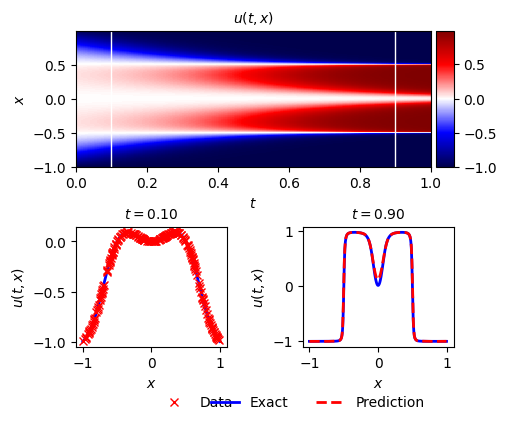

In [18]:
fig